In [1]:
# import libraries
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as k
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(2017)
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Add, Flatten, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.datasets import cifar10


from keras.preprocessing import image
import keras.backend as K
import cv2
import sys
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
# load data
(X_train1, y_train1),(X_test1, y_test1) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
# View images

# check the shape of the data set

print(X_train1.shape) # 50k images of size 32X32 and 3 channels
print(X_test1.shape) # 10 k images

#num_train,img_channels, img_rows, img_cols = train_features.shape[0], train_features.shape[3],train_features.shape[1],train_features.shape[2]

num_train, img_rows, img_cols,img_channels = X_train1.shape
print(num_train, img_channels, img_rows, img_cols)

num_test, _, _, _ = X_test1.shape
num_classes = len(np.unique(y_train1))
print(num_classes)
print(y_train1[:])

(50000, 32, 32, 3)
(10000, 32, 32, 3)
50000 3 32 32
10
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


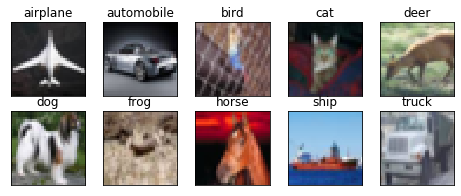

In [4]:
# plot 10 classified images with cutouts
# plot the images random selection

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
  ax = fig.add_subplot(2,5, 1+i, xticks=[], yticks=[])
  idx = np.where(y_train1[:]==i)[0] # gets the index values for image number = i
  features_idx = X_train1[idx,::] # feature values for idx labes is stored in features_idx.
  img_num = np.random.randint(features_idx.shape[0]) # select a random number from the feature_idx
  im = features_idx[img_num]
  ax.set_title(class_names[i])
  #print(class_names[int(train_labels[img_num])], train_labels[img_num])
  #im = eraser(im)
  plt.imshow(im)

plt.show()

In [0]:
def create_gradcam(org_image,models,last_block,num_channels):

  org_image = np.asarray(org_image)
  img = image.img_to_array(org_image)
  img = np.expand_dims(img,axis=0)
  #print(img.max(), img.min(), img.mean())
  #img = preprocess_input(img) # in your model, change this to image normalization tecnique that you had performed. 
  img = img.astype('float32')/255


  predict = models.predict(img)
  class_idx = np.argmax(predict[0])
  class_output = models.output[:,class_idx]
  last_conv_layer = models.get_layer(last_block)

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([models.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img])
  for i in range(num_channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (org_image.shape[1], org_image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(org_image, 0.7, heatmap, 0.3, 0)
  plt.imshow(superimposed_img)


  return class_idx,img.shape,heatmap.shape


In [0]:
# plot model histrory function
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Print Accuracy Function

def accuracy(test_x, test_y, model):
  result = model.predict(test_x)
  predicted_class = np.argmax(result, axis=1)
  true_class = np.argmax(test_y, axis=1)
  num_correct = np.sum(predicted_class == true_class)
  accuracy = float(num_correct)/result.shape[0]
  return accuracy*100

In [0]:

# image normalize and one hot encoding
X_train = X_train1.astype('float32')/255
X_test = X_test1.astype('float32')/255
# convert class labels to binary class labels
y_train = np_utils.to_categorical(y_train1, num_classes)
y_test = np_utils.to_categorical(y_test1, num_classes)

In [9]:
# Model Architecture

# Model2 Fix Architecture
modelb = Sequential()

modelb.add(Convolution2D(32,3,3, border_mode ='same', activation='relu',input_shape=(32,32,3))) #RF 3
modelb.add(BatchNormalization())
modelb.add(Dropout(0.1))
modelb.add(Convolution2D(32,3,3, border_mode='same', activation='relu')) #RF 5
modelb.add(BatchNormalization())
modelb.add(Dropout(0.1))
modelb.add(Convolution2D(32,3,3, border_mode='same', activation='relu')) #RF7
modelb.add(BatchNormalization())
modelb.add(Dropout(0.1))

modelb.add(MaxPooling2D(pool_size=(2,2))) #RF14
modelb.add(Convolution2D(16,1,1, activation='relu')) #RF 14
modelb.add(Dropout(0.1))

modelb.add(Convolution2D(64,3,3, border_mode='same', activation='relu')) #RF 16
modelb.add(BatchNormalization())
modelb.add(Dropout(0.1))
modelb.add(Convolution2D(64,3,3, border_mode='same', activation='relu')) #RF 18
modelb.add(BatchNormalization())
modelb.add(Dropout(0.1))


modelb.add(MaxPooling2D(pool_size=(2,2))) #RF 32
modelb.add(Convolution2D(64,1,1, activation='relu'))
modelb.add(Dropout(0.1))

### Add one more 8x8 layer
modelb.add(Convolution2D(64,3,3, border_mode='same', activation='relu')) #RF 18
modelb.add(BatchNormalization())
modelb.add(Dropout(0.1))

modelb.add(GlobalAveragePooling2D())
modelb.add(Activation('relu'))
modelb.add(Dense(10))

modelb.add(Activation('softmax'))

modelb.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`


In [0]:
class LrRangeFinder(tf.keras.callbacks.Callback):
  def __init__(self, start_lr, end_lr):
    super().__init__()
    self.start_lr = start_lr
    self.end_lr = end_lr

  def on_train_begin(self, logs={}):
    self.lrs = []
    self.losses = []
    tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)

    n_steps = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
    n_steps *= self.params['epochs']
    self.by = (self.end_lr - self.start_lr) / n_steps


  def on_batch_end(self, batch, logs={}):
    lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
    self.lrs.append(lr)
    self.losses.append(logs.get('loss'))
    lr += self.by
    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

In [0]:
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        self.steps_per_epoch = self.params['steps'] if self.params['steps'] is not None else round(self.params['samples'] / self.params['batch_size'])
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [12]:
epochs = 50
lrRangeFinder = LrRangeFinder(start_lr=0.1, end_lr=0.0009)

#model_cnn_0 = model()
from keras.optimizers import SGD

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)  #decay=1e-2/epochs
modelb.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer=sgd,
                    metrics=['accuracy'])

#model.fit(train_features, train_labels, epochs=epochs, batch_size=128, callbacks=[lrRangeFinder])

In [0]:
# Compile the model
#modelb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<__main__..., verbose=1, steps_per_epoch=390, epochs=50)`
  del sys.path[0]




Epoch 1/50
390/390 [==============================] - 17s 43ms/step - loss: 1.5537 - acc: 0.4299 - val_loss: 1.5169 - val_acc: 0.4345
Epoch 2/50
390/390 [==============================] - 9s 24ms/step - loss: 1.1771 - acc: 0.5751 - val_loss: 1.1509 - val_acc: 0.5785
Epoch 3/50
390/390 [==============================] - 9s 24ms/step - loss: 1.0210 - acc: 0.6334 - val_loss: 1.0293 - val_acc: 0.6285
Epoch 4/50
390/390 [==============================] - 9s 24ms/step - loss: 0.9280 - acc: 0.6701 - val_loss: 1.0244 - val_acc: 0.6364
Epoch 5/50
390/390 [==============================] - 9s 24ms/step - loss: 0.8621 - acc: 0.6928 - val_loss: 0.9426 - val_acc: 0.6618
Epoch 6/50
390/390 [==============================] - 9s 24ms/step - loss: 0.8019 - acc: 0.7151 - val_loss: 1.0063 - val_acc: 0.6455
Epoch 7/50
390/390 [==============================] - 9s 24ms/step - loss: 0.7486 - acc: 0.7354 - val_loss: 0.8835 - val_acc: 0.6902
Epoch 8/50
390/390 [==============================] - 9s 24ms/step

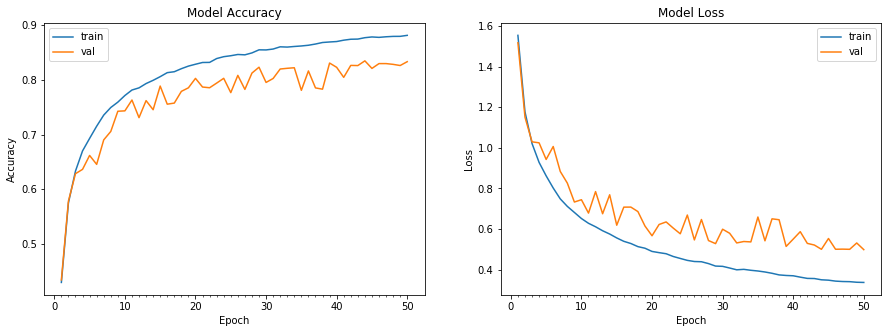

Accuracy on test data is: 83.30


In [14]:
#modelb.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
#         validation_data=(X_test,y_test))


########################################## fit the model using image data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             )


# train the model
start = time.time()
# Train the model
model_info = modelb.fit_generator(datagen.flow(X_train, y_train, batch_size = 128),
                                 samples_per_epoch = X_train.shape[0], nb_epoch = epochs, 
                                 validation_data = (X_test, y_test), callbacks=[lrRangeFinder], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, y_test, modelb))

In [15]:

predictions = modelb.predict_classes(X_test)

print(y_test[0:10] ,'\n', predictions[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] 
 [3 8 8 8 6 6 1 6 3 1]


In [16]:
print(y_test1[0:10],'\n',predictions[0:10])

print(len(y_test1))
wrong_class = []
for i in range(len(y_test1)):
  if predictions[i] != y_test1[i]:
    wrong_class += [i]

print(len(wrong_class))    


[[3]
 [8]
 [8]
 [0]
 [6]
 [6]
 [1]
 [6]
 [3]
 [1]] 
 [3 8 8 8 6 6 1 6 3 1]
10000
1670


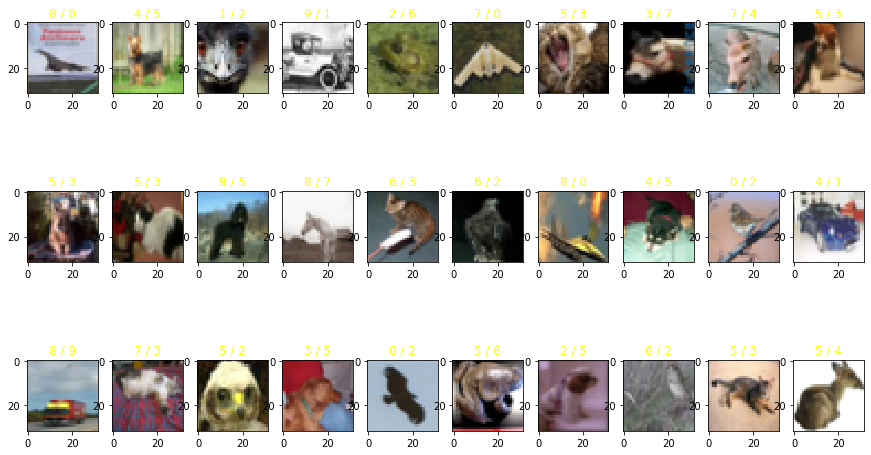

In [17]:
import matplotlib.cm as cm

fig, axs = plt.subplots(1,5, figsize=(15,15))
#fig.subplots_adjust(hspace=.5, wspace=0.001)
#axs = axs.ravel()

for i in range(30):
  plt.subplot(5,10,i+1)
  plt.title('%d / %d'% (predictions[wrong_class[i]],y_test1[wrong_class[i]]), color='yellow')
  plt.imshow(X_test1[wrong_class[i]], cmap=cm.binary)  

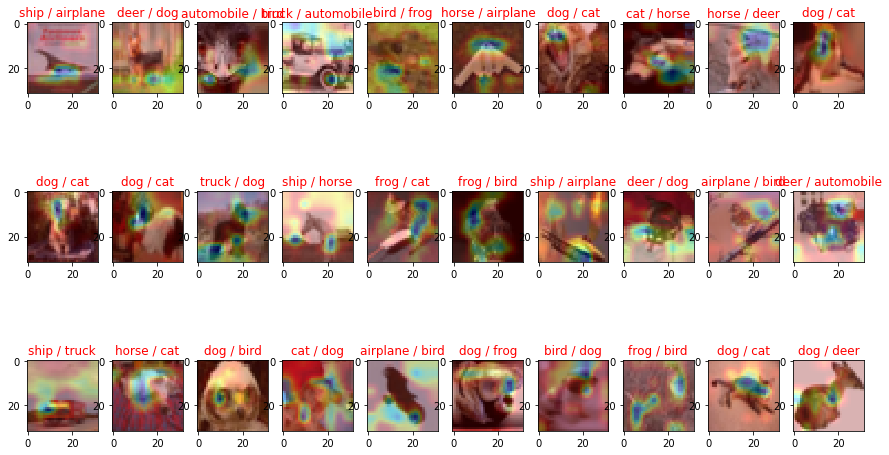

In [20]:
import matplotlib.cm as cm
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

last_block = "conv2d_8"
num_channels = 64

fig, axs = plt.subplots(1,5, figsize=(15,15))
#fig.subplots_adjust(hspace=.5, wspace=0.001)
#axs = axs.ravel()

for i in range(30):
  plt.subplot(5,10,i+1)
  #plt.title('%d / %d'% (class_names[int(predictions[wrong_class[i]])],y_test1[wrong_class[i]]), color='yellow')
  plt.title('%s / %s'% (class_names[int(predictions[wrong_class[i]])],class_names[int(y_test1[wrong_class[i]])]), color='Red')
  #plt.imshow(X_test1[wrong_class[i]], cmap=cm.binary) 
  x = X_test1[wrong_class[i]]
  create_gradcam(x,modelb,last_block,num_channels)

In [21]:
class_names[int(predictions[wrong_class[1]])]

'deer'

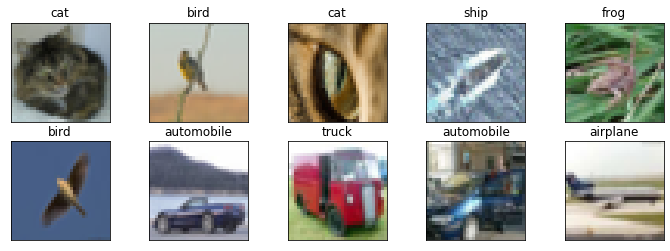

In [22]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(12,4))
                          
for i in range(10):
  ax = fig.add_subplot(2,5, 1+i, xticks=[], yticks=[])
  #idx = y_test[i][0]
  idx = np.random.randint(y_test1.shape[0])
  #x = X_test[i]
  x = X_test[idx]
  #create_gradcam(x,modelb,last_block,num_channels)
  plt.imshow(X_test1[idx])
  ax.set_title(class_names[int(y_test1[idx])])


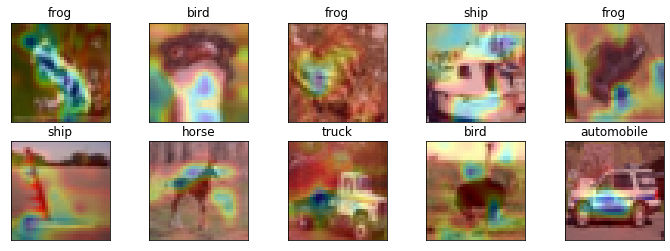

In [23]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

last_block = "conv2d_8"
num_channels = 64

fig = plt.figure(figsize=(12,4))
                          
for i in range(10):
  ax = fig.add_subplot(2,5, 1+i, xticks=[], yticks=[])
  #idx = y_test[i][0]

  idx = np.random.randint(y_test1.shape[0])
  #x = X_test[i]
  x = X_test1[idx]
  create_gradcam(x,modelb,last_block,num_channels)
  #plt.imshow(X_test[i])
  ax.set_title(class_names[int(y_test1[idx])])
